Cat vs Dog Classifier

In [2]:
# !pip install bing-image-downloader
import os
import requests

import mlflow
import mlflow.keras
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import MobileNet

from datetime import datetime
import matplotlib.pyplot as plt

from bing_image_downloader import downloader
from pathlib import Path
import imghdr
import numpy as np


2025-02-20 06:27:14.889176: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-20 06:27:14.897321: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-20 06:27:14.972299: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-20 06:27:15.037804: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1740032835.117876    1348 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1740032835.13

Download images

In [3]:
image_path = "./data/cat_dogs/"

In [ ]:
def download_images(query, limit, output_dir):
    
    downloader.download(query,
                        limit=limit,
                        output_dir=output_dir,
                        adult_filter_off=True,
                        force_replace=False,
                        timeout=60)

download_images("cat", 100, image_path)
download_images("dog", 100, image_path)

[%] Downloading Images to /home/megha/my_mlflow_project/Project/data/cat_dogs/cat


[!!]Indexing page: 1

[%] Indexed 95 Images on Page 1.


[%] Downloading Image #1 from http://upload.wikimedia.org/wikipedia/commons/c/c7/Domestic_shorthaired_cat_face.jpg
[%] File Downloaded !

[%] Downloading Image #2 from https://images.pexels.com/photos/1643457/pexels-photo-1643457.jpeg?cs=srgb&amp;dl=adorable-animal-cat-1643457.jpg&amp;fm=jpg
[%] File Downloaded !

[%] Downloading Image #3 from https://static.vecteezy.com/system/resources/previews/002/098/203/non_2x/silver-tabby-cat-sitting-on-green-background-free-photo.jpg
[%] File Downloaded !

[%] Downloading Image #4 from https://media.4-paws.org/5/b/4/b/5b4b5a91dd9443fa1785ee7fca66850e06dcc7f9/VIER PFOTEN_2019-12-13_209-2890x2000-1920x1329.jpg
[!] Issue getting: https://media.4-paws.org/5/b/4/b/5b4b5a91dd9443fa1785ee7fca66850e06dcc7f9/VIER PFOTEN_2019-12-13_209-2890x2000-1920x1329.jpg
[!] Error:: URL can't contain control characters. '/5/b/4/

Check the downloaded images

In [5]:
for category in ["cat", "dog"]:
    data_dir = os.path.join(image_path, category)  # Set the directory path for each category
    image_extensions = [".png", ".jpg", ".jpeg", ".bmp", ".gif"]  # Add all common image formats

    img_type_accepted_by_tf = ["bmp", "gif", "jpeg", "png"]  # TensorFlow-supported formats

    for filepath in Path(data_dir).rglob("*"):  # Iterate through all files
        if filepath.suffix.lower() in image_extensions:
            img_type = imghdr.what(filepath)  # Check if it's a valid image

            if img_type is None:
                print(f"Deleting {filepath}: Not a valid image")
                os.remove(filepath)  # Delete invalid image

            elif img_type not in img_type_accepted_by_tf:
                print(f"Deleting {filepath}: {img_type} is not accepted by TensorFlow")
                os.remove(filepath)  # Delete unsupported image type

Model Training

Define parameters

In [6]:
# Define hyperparameters and input data
learning_rate = 0.01
num_epochs = 50
batch_size = 32
input_shape = (224, 224, 3)

In [7]:
# Define names for tensorboard logging and mlflow
experiment_name = "cat-dog-classifier-mobilenet"
run_name = datetime.now().strftime("%Y%m%d_%H%M%S")

Read Data

In [8]:
# Load the dataset
train_dataset = keras.preprocessing.image_dataset_from_directory(
    image_path,
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=input_shape[:2],
    batch_size=batch_size,
)

Found 197 files belonging to 2 classes.
Using 158 files for training.


2025-02-20 06:27:24.648809: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [9]:
val_dataset = keras.preprocessing.image_dataset_from_directory(
    image_path,
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=input_shape[:2],
    batch_size=batch_size,
)

Found 197 files belonging to 2 classes.
Using 39 files for validation.


Look at some sample images from the datasets

2025-02-20 06:27:28.792804: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


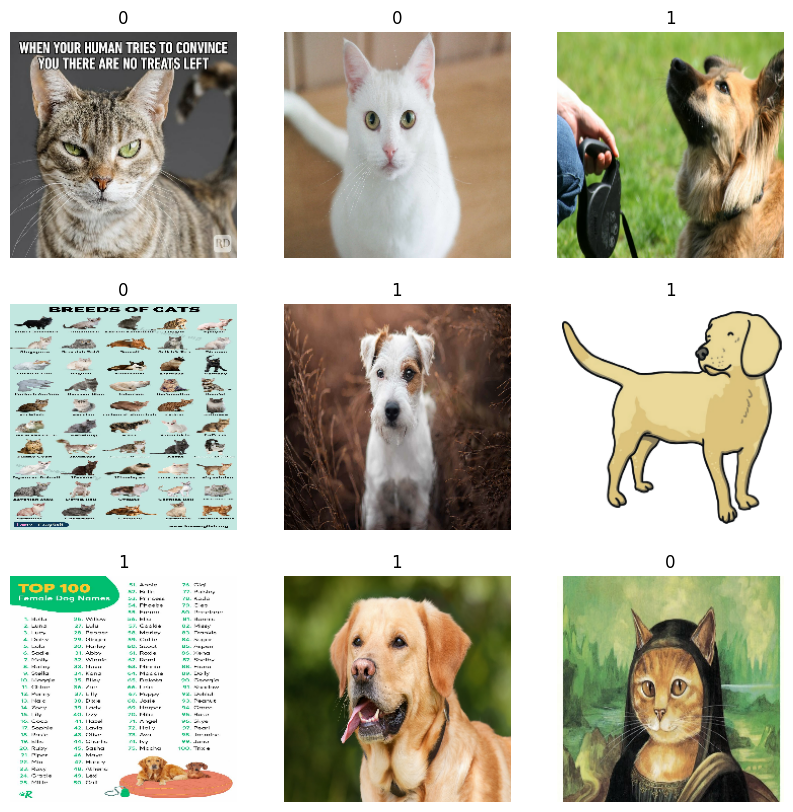

In [10]:
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

2025-02-20 06:31:00.067252: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


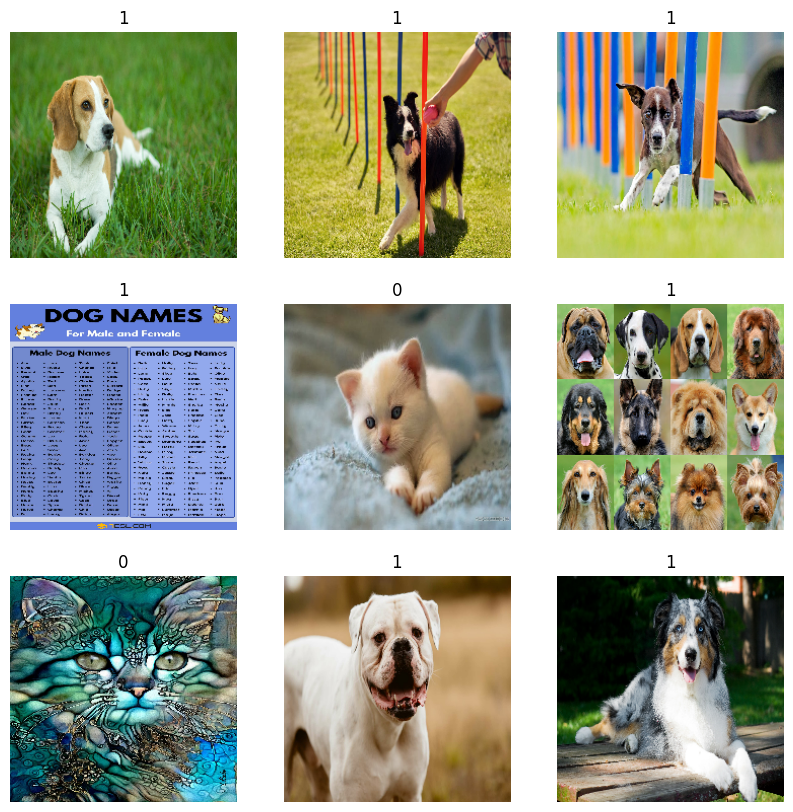

In [11]:
plt.figure(figsize=(10, 10))
for images, labels in val_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

Data Augmentation

In [12]:
data_augmentation = keras.Sequential(
    [
        keras.layers.RandomFlip("horizontal"),
        keras.layers.RandomRotation(0.1),
    ]
)

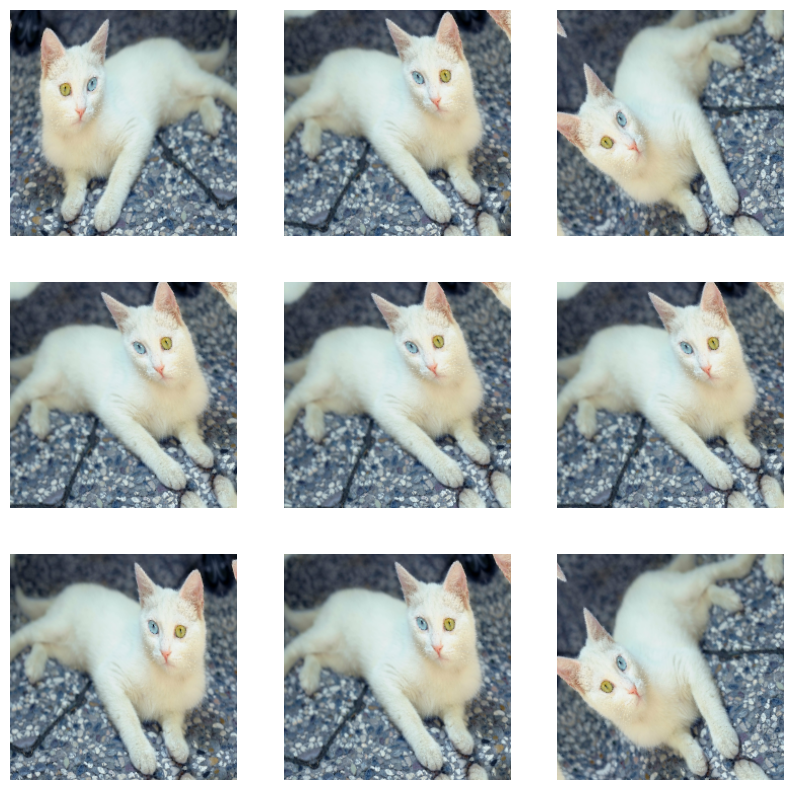

In [13]:
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images, training=True)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [15]:
augmented_train_dataset = train_dataset.map(
    lambda x, y: (data_augmentation(x, training=True), y))

Define Model and Train

In [16]:
# Define the base model and add a classifier on top
base_model = MobileNet(input_shape=input_shape, include_top=False, weights="imagenet")
base_model.trainable = False
model = keras.Sequential([
    base_model,
    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dense(2, activation="softmax")
])

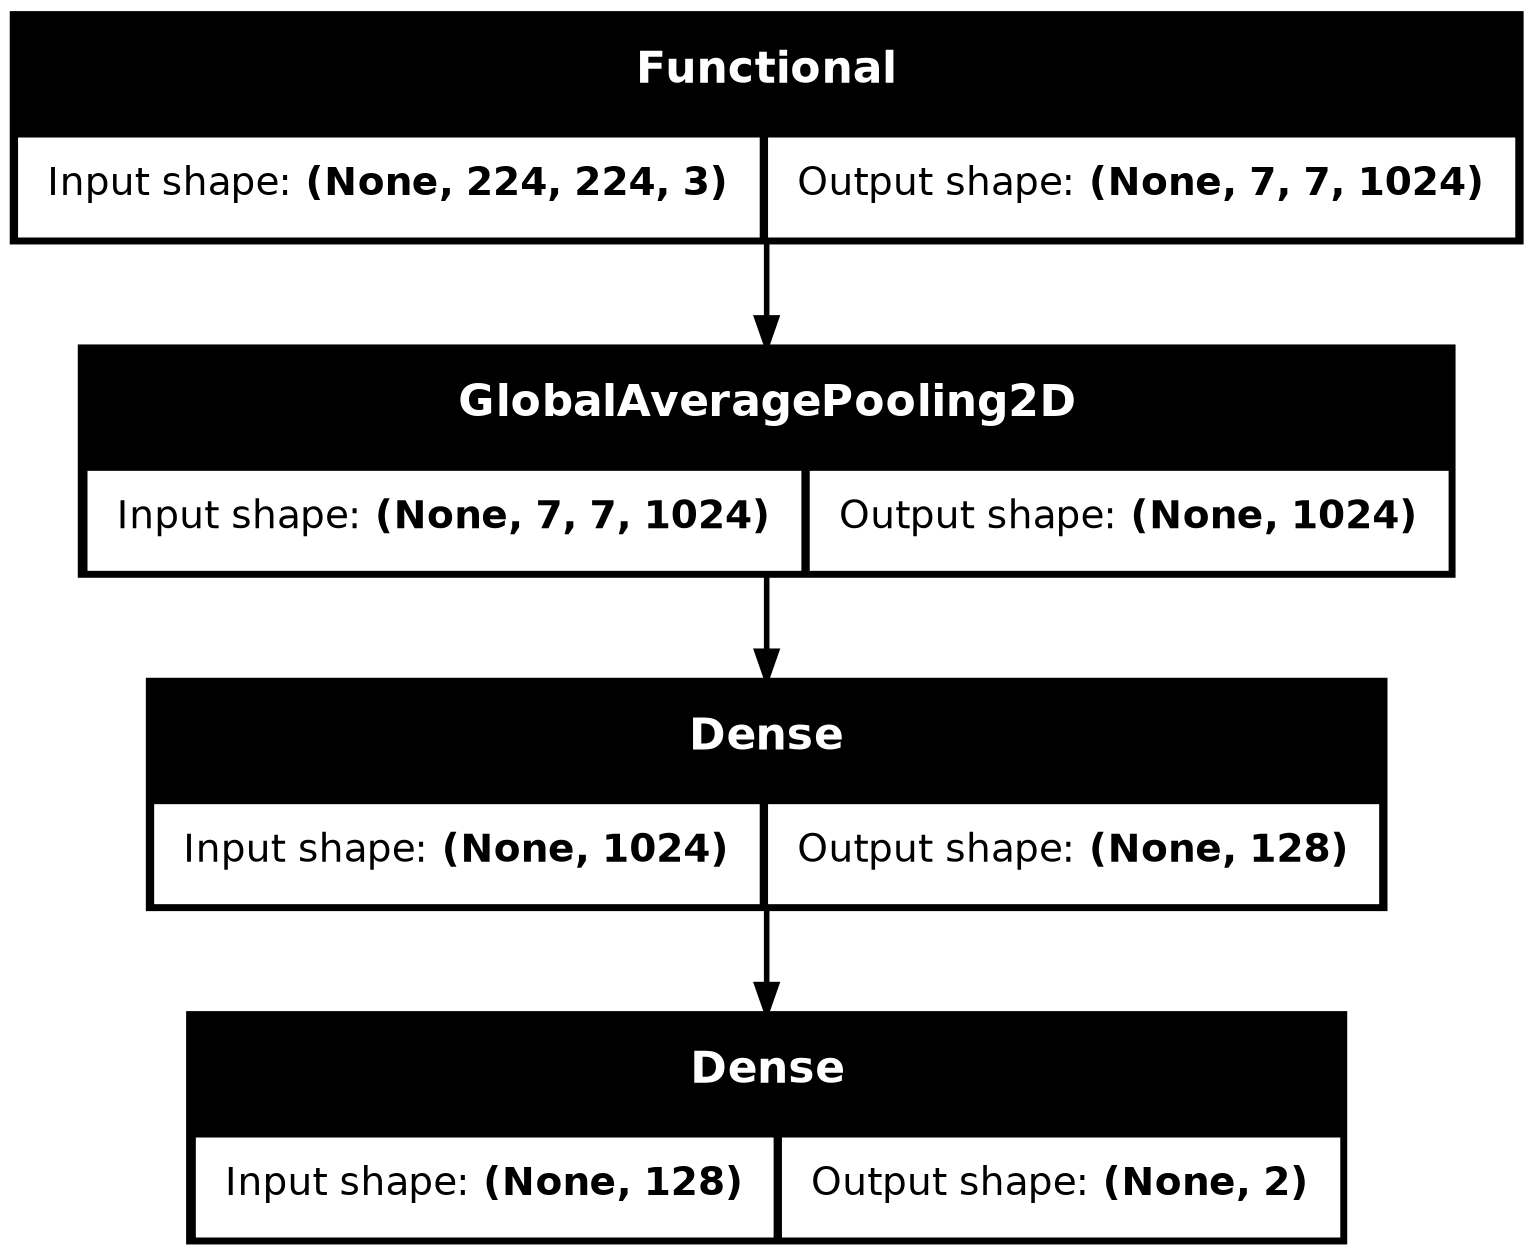

In [17]:
keras.utils.plot_model(model, show_shapes=True)

In [18]:
 # Compile the model with a loss function and optimizer
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
    metrics=["accuracy"],
)

In [19]:
logdir = os.path.join("logs", experiment_name, run_name)
tb_callback = keras.callbacks.TensorBoard(log_dir=logdir, write_graph=True, histogram_freq=1)

In [25]:
# Train the model and log metrics and the model itself to MLflow
history = model.fit(
    augmented_train_dataset,
    epochs=num_epochs,
    validation_data=val_dataset,
    verbose=2,
    callbacks=[tb_callback]
)

Epoch 1/50


2025-02-20 07:25:27.365310: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


5/5 - 3s - 610ms/step - accuracy: 0.9494 - loss: 0.1119 - val_accuracy: 0.9231 - val_loss: 0.1074
Epoch 2/50


2025-02-20 07:25:30.637042: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


5/5 - 3s - 606ms/step - accuracy: 0.9747 - loss: 0.0684 - val_accuracy: 0.9744 - val_loss: 0.0955
Epoch 3/50


2025-02-20 07:25:33.748848: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


5/5 - 0s - 92ms/step - accuracy: 0.9684 - loss: 0.0949 - val_accuracy: 0.8974 - val_loss: 0.1910
Epoch 4/50


2025-02-20 07:25:33.937649: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


5/5 - 3s - 603ms/step - accuracy: 0.9684 - loss: 0.0868 - val_accuracy: 0.9231 - val_loss: 0.1737
Epoch 5/50


2025-02-20 07:25:36.964263: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


5/5 - 3s - 597ms/step - accuracy: 0.9810 - loss: 0.0804 - val_accuracy: 0.9231 - val_loss: 0.1315
Epoch 6/50


2025-02-20 07:25:39.938327: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


5/5 - 3s - 614ms/step - accuracy: 0.9747 - loss: 0.0777 - val_accuracy: 0.9231 - val_loss: 0.1538
Epoch 7/50


2025-02-20 07:25:42.957950: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


5/5 - 3s - 622ms/step - accuracy: 0.9620 - loss: 0.0819 - val_accuracy: 0.9487 - val_loss: 0.1026
Epoch 8/50


2025-02-20 07:25:46.461942: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


5/5 - 3s - 659ms/step - accuracy: 0.9873 - loss: 0.0556 - val_accuracy: 0.9744 - val_loss: 0.0788
Epoch 9/50


2025-02-20 07:25:49.721164: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


5/5 - 4s - 700ms/step - accuracy: 0.9810 - loss: 0.0583 - val_accuracy: 0.9744 - val_loss: 0.0884
Epoch 10/50


2025-02-20 07:25:52.923923: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


5/5 - 4s - 738ms/step - accuracy: 0.9873 - loss: 0.0776 - val_accuracy: 0.9744 - val_loss: 0.0990
Epoch 11/50


2025-02-20 07:25:57.154799: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


5/5 - 4s - 734ms/step - accuracy: 0.9684 - loss: 0.0791 - val_accuracy: 0.9744 - val_loss: 0.0985
Epoch 12/50


2025-02-20 07:26:00.706202: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


5/5 - 4s - 776ms/step - accuracy: 0.9937 - loss: 0.0535 - val_accuracy: 0.9487 - val_loss: 0.1210
Epoch 13/50


2025-02-20 07:26:04.253658: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


5/5 - 1s - 215ms/step - accuracy: 0.9937 - loss: 0.0434 - val_accuracy: 0.9487 - val_loss: 0.1526
Epoch 14/50


2025-02-20 07:26:05.360390: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


5/5 - 4s - 701ms/step - accuracy: 0.9747 - loss: 0.0972 - val_accuracy: 0.8974 - val_loss: 0.1369
Epoch 15/50


2025-02-20 07:26:09.200204: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


5/5 - 4s - 708ms/step - accuracy: 0.9810 - loss: 0.0485 - val_accuracy: 0.9487 - val_loss: 0.1029
Epoch 16/50


2025-02-20 07:26:12.376143: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


5/5 - 4s - 701ms/step - accuracy: 0.9747 - loss: 0.0542 - val_accuracy: 0.9487 - val_loss: 0.1247
Epoch 17/50


2025-02-20 07:26:15.827549: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


5/5 - 4s - 703ms/step - accuracy: 0.9810 - loss: 0.0485 - val_accuracy: 0.8974 - val_loss: 0.1747
Epoch 18/50


2025-02-20 07:26:19.616558: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


5/5 - 4s - 708ms/step - accuracy: 0.9747 - loss: 0.0598 - val_accuracy: 0.8974 - val_loss: 0.1334
Epoch 19/50


2025-02-20 07:26:22.967771: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


5/5 - 4s - 714ms/step - accuracy: 0.9873 - loss: 0.0502 - val_accuracy: 0.9487 - val_loss: 0.1361
Epoch 20/50


2025-02-20 07:26:26.462904: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


5/5 - 4s - 703ms/step - accuracy: 0.9810 - loss: 0.0493 - val_accuracy: 0.9487 - val_loss: 0.1463
Epoch 21/50


2025-02-20 07:26:30.063884: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


5/5 - 4s - 770ms/step - accuracy: 0.9937 - loss: 0.0397 - val_accuracy: 0.9487 - val_loss: 0.1222
Epoch 22/50


2025-02-20 07:26:33.866481: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


5/5 - 1s - 207ms/step - accuracy: 0.9747 - loss: 0.0732 - val_accuracy: 0.9231 - val_loss: 0.1445
Epoch 23/50


2025-02-20 07:26:34.991716: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


5/5 - 4s - 701ms/step - accuracy: 0.9873 - loss: 0.0490 - val_accuracy: 0.9231 - val_loss: 0.2050
Epoch 24/50


2025-02-20 07:26:38.304739: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


5/5 - 4s - 716ms/step - accuracy: 0.9747 - loss: 0.0673 - val_accuracy: 0.8974 - val_loss: 0.1736
Epoch 25/50


2025-02-20 07:26:42.381364: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


5/5 - 4s - 719ms/step - accuracy: 0.9873 - loss: 0.0426 - val_accuracy: 0.9231 - val_loss: 0.1280
Epoch 26/50


2025-02-20 07:26:46.026077: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


5/5 - 4s - 710ms/step - accuracy: 0.9873 - loss: 0.0424 - val_accuracy: 0.9487 - val_loss: 0.0982
Epoch 27/50


2025-02-20 07:26:49.054430: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


5/5 - 4s - 714ms/step - accuracy: 0.9873 - loss: 0.0435 - val_accuracy: 0.8205 - val_loss: 0.4149
Epoch 28/50


2025-02-20 07:26:52.848640: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


5/5 - 4s - 715ms/step - accuracy: 0.9684 - loss: 0.1112 - val_accuracy: 0.8718 - val_loss: 0.2416
Epoch 29/50


2025-02-20 07:26:56.144132: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


5/5 - 4s - 707ms/step - accuracy: 0.9367 - loss: 0.1357 - val_accuracy: 0.8974 - val_loss: 0.1903
Epoch 30/50


2025-02-20 07:26:59.876021: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


5/5 - 4s - 714ms/step - accuracy: 0.9494 - loss: 0.1072 - val_accuracy: 0.8718 - val_loss: 0.5184
Epoch 31/50


2025-02-20 07:27:03.253879: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


5/5 - 1s - 219ms/step - accuracy: 0.9494 - loss: 0.1238 - val_accuracy: 0.8974 - val_loss: 0.1528
Epoch 32/50


2025-02-20 07:27:04.941372: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


5/5 - 4s - 738ms/step - accuracy: 0.9873 - loss: 0.0610 - val_accuracy: 0.9487 - val_loss: 0.1246
Epoch 33/50


2025-02-20 07:27:08.270810: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


5/5 - 4s - 711ms/step - accuracy: 0.9620 - loss: 0.0766 - val_accuracy: 0.9231 - val_loss: 0.2748
Epoch 34/50


2025-02-20 07:27:11.612898: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


5/5 - 4s - 725ms/step - accuracy: 0.9620 - loss: 0.0907 - val_accuracy: 0.8718 - val_loss: 0.3315
Epoch 35/50


2025-02-20 07:27:15.311157: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


5/5 - 4s - 769ms/step - accuracy: 0.9557 - loss: 0.1394 - val_accuracy: 0.8205 - val_loss: 0.4613
Epoch 36/50


2025-02-20 07:27:19.184895: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


5/5 - 4s - 722ms/step - accuracy: 0.9367 - loss: 0.1320 - val_accuracy: 0.9744 - val_loss: 0.1069
Epoch 37/50


2025-02-20 07:27:22.909995: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


5/5 - 4s - 734ms/step - accuracy: 0.9494 - loss: 0.0875 - val_accuracy: 0.9487 - val_loss: 0.1227
Epoch 38/50


2025-02-20 07:27:26.363968: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


5/5 - 4s - 721ms/step - accuracy: 0.9557 - loss: 0.0733 - val_accuracy: 0.9487 - val_loss: 0.1523
Epoch 39/50


2025-02-20 07:27:30.321782: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


5/5 - 4s - 722ms/step - accuracy: 0.9937 - loss: 0.0307 - val_accuracy: 0.9231 - val_loss: 0.1461
Epoch 40/50


2025-02-20 07:27:33.746350: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


5/5 - 1s - 231ms/step - accuracy: 0.9937 - loss: 0.0332 - val_accuracy: 0.9231 - val_loss: 0.2271
Epoch 41/50


2025-02-20 07:27:34.850786: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


5/5 - 4s - 730ms/step - accuracy: 0.9810 - loss: 0.0547 - val_accuracy: 0.9744 - val_loss: 0.1144
Epoch 42/50


2025-02-20 07:27:38.749876: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


5/5 - 4s - 756ms/step - accuracy: 0.9937 - loss: 0.0281 - val_accuracy: 0.9744 - val_loss: 0.1389
Epoch 43/50


2025-02-20 07:27:42.451048: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


5/5 - 4s - 848ms/step - accuracy: 0.9873 - loss: 0.0384 - val_accuracy: 0.9231 - val_loss: 0.1412
Epoch 44/50


2025-02-20 07:27:47.037123: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


5/5 - 5s - 919ms/step - accuracy: 0.9747 - loss: 0.0643 - val_accuracy: 0.8205 - val_loss: 0.3815
Epoch 45/50


2025-02-20 07:27:51.014559: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


5/5 - 4s - 789ms/step - accuracy: 0.9810 - loss: 0.0734 - val_accuracy: 0.8718 - val_loss: 0.3218
Epoch 46/50


2025-02-20 07:27:55.151106: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


5/5 - 4s - 761ms/step - accuracy: 0.9620 - loss: 0.0697 - val_accuracy: 0.8462 - val_loss: 0.3939
Epoch 47/50


2025-02-20 07:27:58.846151: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


5/5 - 4s - 822ms/step - accuracy: 0.9241 - loss: 0.1711 - val_accuracy: 0.9744 - val_loss: 0.1985
Epoch 48/50


2025-02-20 07:28:03.286695: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


5/5 - 1s - 217ms/step - accuracy: 0.9557 - loss: 0.1281 - val_accuracy: 0.9487 - val_loss: 0.0830
Epoch 49/50


2025-02-20 07:28:04.353370: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


5/5 - 4s - 748ms/step - accuracy: 0.9747 - loss: 0.0712 - val_accuracy: 0.8974 - val_loss: 0.1892
Epoch 50/50


2025-02-20 07:28:07.711064: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


5/5 - 4s - 741ms/step - accuracy: 0.9494 - loss: 0.0849 - val_accuracy: 0.9231 - val_loss: 0.1654


Logging and Visualization

In [38]:
# Set the experiment name and create an MLflow run
mlflow.set_experiment(experiment_name)
with mlflow.start_run(run_name = run_name) as mlflow_run:
    
    mlflow.set_experiment_tag("base_model", "MobileNet")
    mlflow.set_tag("optimizer", "keras.optimizers.Adam")
    mlflow.set_tag("loss", "sparse_categorical_crossentropy")

    mlflow.keras.log_model(model, "model")

    mlflow.log_param("learning_rate", learning_rate)
    mlflow.log_param("num_epochs", num_epochs)
    mlflow.log_param("batch_size", batch_size)
    mlflow.log_param("input_shape", input_shape)

    mlflow.log_metric("train_loss", history.history["loss"][-1])
    mlflow.log_metric("train_acc", history.history["accuracy"][-1])
    mlflow.log_metric("val_loss", history.history["val_loss"][-1])
    mlflow.log_metric("val_acc", history.history["val_accuracy"][-1])

    mlflow.log_artifact("model.png", "model_plot")

    mlflow_run_id = mlflow_run.info.run_id
    print("MLFlow Run ID: ", mlflow_run_id)

2025/02/20 07:28:18 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2025/02/20 07:28:23 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLFlow Run ID:  9f2cc221265f4511aa269464bb210706


MLFlow Run ID:  5679393ab9f04ad7b30687a456825009 for 19-02-2025  

MLFlow Run ID:  3c1eba254bb54b97813ba31299628899 for 20-02-2025 


Using Tensorboard within Jupyter

In [39]:
%load_ext tensorboard
%tensorboard --logdir logs/cat-dog-classifier-mobilenet

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 6215), started 0:03:30 ago. (Use '!kill 6215' to kill it.)

Reusing TensorBoard on port 6006 (pid 29392), started 6:25:12 ago. (Use '!kill 29392' to kill it.)

Predictions

In [40]:
img = keras.preprocessing.image.load_img(
    os.path.join(image_path, "dog/Image_5.jpg"), target_size=input_shape
    # os.path.join(image_path, "cat/Image_2.jpg"), target_size=input_shape
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
Raw model predictions: [0.00356807 0.99643195]
This image is 0.36% dog and 99.64% cat.


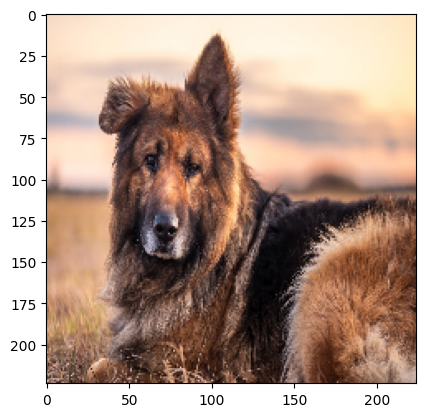

In [41]:
predictions = model.predict(img_array)
print("Raw model predictions:", predictions[0])

print("This image is {:.2f}% dog and {:.2f}% cat.".format(100 * float(predictions[0][0]),
                                                          100 * float(predictions[0][1])))

plt.imshow(img_array[0].numpy().astype("uint8"))

Using MLFlow to predict

In [42]:
# Logged model in MLFlow
logged_model_path = f"runs:/{mlflow_run_id}/model"

# Load model as a Keras model
loaded_model = mlflow.keras.load_model(logged_model_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step
This image is 0.36% dog and 99.64% cat.


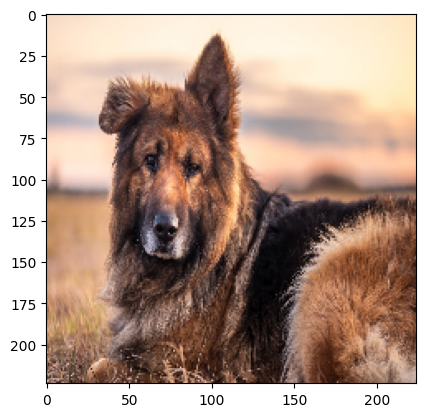

In [43]:
predictions = loaded_model.predict(img_array)
print("This image is {:.2f}% dog and {:.2f}% cat.".format(100 * float(predictions[0][0]),
                                                          100 * float(predictions[0][1])))

plt.imshow(img_array[0].numpy().astype("uint8"))

Model Registration

In [44]:
model_name = "cat_dog_classifier"
model_version = 1

In [45]:
print("MLFlow Run ID: ", mlflow_run_id)

MLFlow Run ID:  9f2cc221265f4511aa269464bb210706


In [46]:
with mlflow.start_run(run_id=mlflow_run_id) as run:
    result = mlflow.register_model(
        logged_model_path,
        model_name
    )

Registered model 'cat_dog_classifier' already exists. Creating a new version of this model...
Created version '3' of model 'cat_dog_classifier'.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step
This image is 75.52% dog and 24.48% cat.


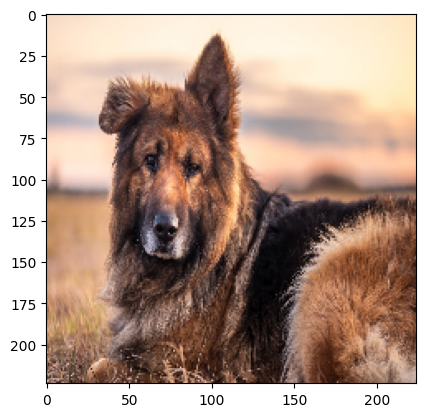

In [47]:
# Load model as a Keras model
loaded_model = mlflow.keras.load_model(
    model_uri=f"models:/{model_name}/{model_version}"
)

predictions = loaded_model.predict(img_array)
print("This image is {:.2f}% dog and {:.2f}% cat.".format(100 * float(predictions[0][0]),
                                                          100 * float(predictions[0][1])))

plt.imshow(img_array[0].numpy().astype("uint8"))

Transition model to production

In [52]:
client = mlflow.tracking.MlflowClient()
client.transition_model_version_stage(
    name=model_name,
    version=model_version,
    stage="Production"
)

/tmp/ipykernel_1348/163353590.py:2: FutureWarning: ``mlflow.tracking.client.MlflowClient.transition_model_version_stage`` is deprecated since 2.9.0. Model registry stages will be removed in a future major release. To learn more about the deprecation of model registry stages, see our migration guide here: https://mlflow.org/docs/latest/model-registry.html#migrating-from-stages
  client.transition_model_version_stage(


<ModelVersion: aliases=[], creation_timestamp=1739966178748, current_stage='Production', description=None, last_updated_timestamp=1740036684944, name='cat_dog_classifier', run_id='5679393ab9f04ad7b30687a456825009', run_link=None, source='file:///home/megha/my_mlflow_project/Project/mlruns/929989691142411108/5679393ab9f04ad7b30687a456825009/artifacts/model', status='READY', status_message=None, tags={}, user_id=None, version=1>

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 525ms/step
This image is 75.52% dog and 24.48% cat.


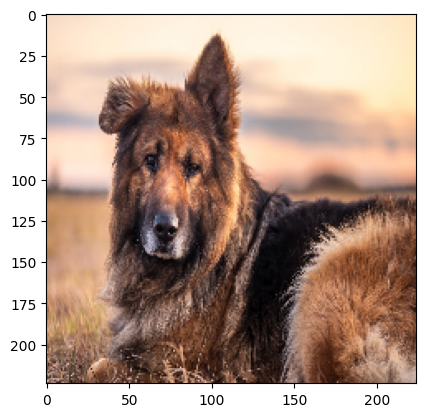

In [53]:
# Load model as a Keras model
loaded_model = mlflow.keras.load_model(
    model_uri=f"models:/{model_name}/production"
)

predictions = loaded_model.predict(img_array)
print("This image is {:.2f}% dog and {:.2f}% cat.".format(100 * float(predictions[0][0]),
                                                          100 * float(predictions[0][1])))

plt.imshow(img_array[0].numpy().astype("uint8"))

Create endpoint for model serving

Set environment variable for MLFlow URI

export MLFLOW_TRACKING_URI=http://localhost:5000

Start MLFlow Server for the model


mlflow models serve --model-uri models:/cat_dog_classifier/production -p 7777 --no-conda

In [56]:
endpoint = "http://localhost:7777/invocations"

This image is 75.52% dog and 24.48% cat.


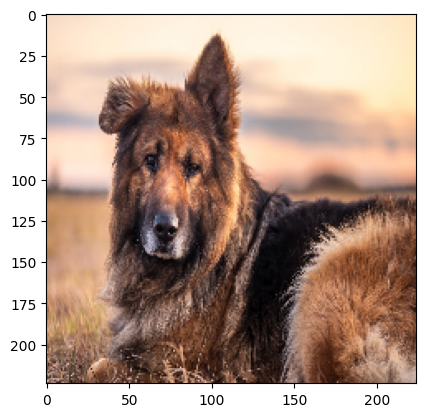

In [57]:
image_request = {
        "instances":img_array.numpy().tolist()
}

response = requests.post(endpoint, json=image_request)

predictions = eval(response.text)["predictions"]
print("This image is {:.2f}% dog and {:.2f}% cat.".format(100 * float(predictions[0][0]),
                                                          100 * float(predictions[0][1])))

plt.imshow(img_array[0].numpy().astype("uint8"))